# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [6]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [7]:
#import sys
#sys.path.append("..")
#!pip install segment_anything
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

# Chest X-ray Dataset

In [ ]:
import os
from torchvision.datasets.utils import download_url

In [ ]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [ ]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [ ]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [ ]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

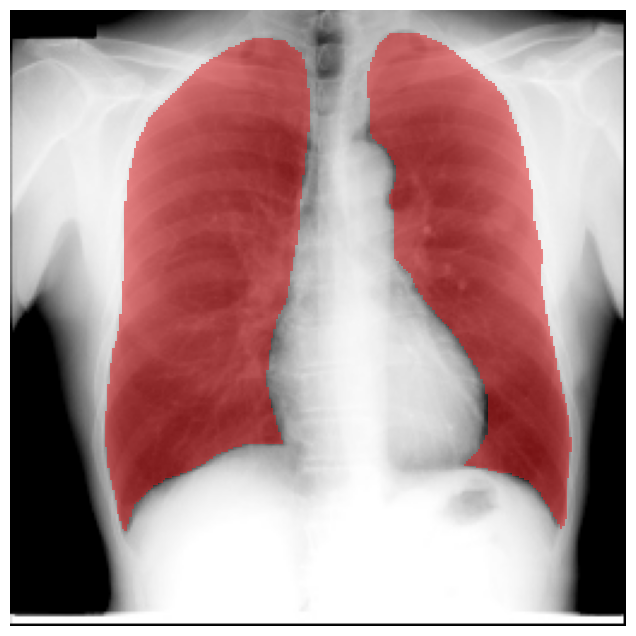

In [ ]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

def convert(image):
    image = image.squeeze()
    image = np.stack([image]*3, axis=3)

    image = image + np.abs(np.min(image))
    return (image / np.max(image) * 255).astype(np.uint8)

x_train = convert(x_train)
y_train = y_train.squeeze()

x_val = convert(x_val)
y_val = y_val.squeeze()

x_test = convert(x_test)
y_test = y_test.squeeze()
# YOUR CODE HERE

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

#assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
#print(x_train[0])
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [ ]:
example_img, example_mask = x_train[0], y_train[0]

input_points =  np.array([[80, 100],[190, 100]])# TODO: Pick apropriate input points,
input_label = np.array([1, 1]) # TODO: Pick apropriate input labels

example_img.shape

(256, 256, 3)

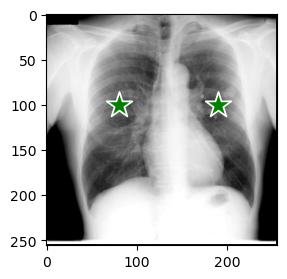

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

/home/jarl/anaconda3/envs/torchvision/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


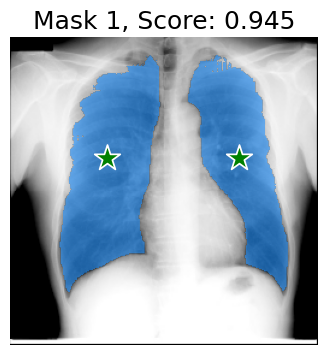

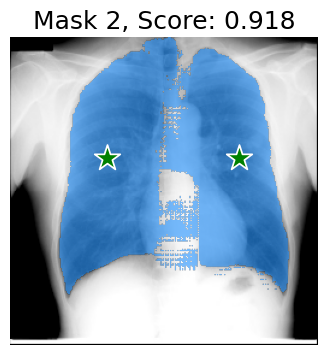

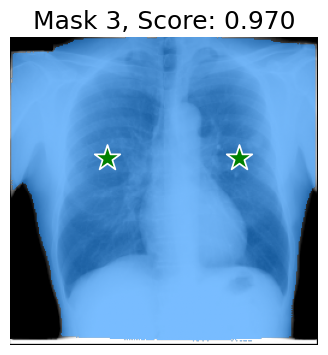

In [ ]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [ ]:
#!pip install torchmetrics
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in zip(x_val, y_val):
    predictor.set_image(img)
    mask, scores, logits = predictor.predict(multimask_output=False, point_coords=input_points, point_labels=input_label)
    f1.update(torch.tensor(mask).squeeze(), torch.tensor(mask_gt))
    f1_scores.append(f1.compute())

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.6249
Standard deviation: 0.0501


# Using Bounding Boxes from GT segmentations as Prompt

In [ ]:
def create_boxes(y):
  bounding_boxes = []

  for mask in y:

      mask_shape = mask.shape[0]
      mask_left = mask[:, 0:int(mask_shape/2)]
      mask_right = mask[:, int(mask_shape/2-1):]


      indexes_nonzero = mask_left.nonzero()

      x_left_upper1 = np.min(indexes_nonzero[1])
      y_left_upper1 = np.min(indexes_nonzero[0])

      x_right_lower1= np.max(indexes_nonzero[1])
      y_right_lower1 = np.max(indexes_nonzero[0])


      indexes_nonzero = mask_right.nonzero()

      x_left_upper2 = int(mask_shape/2) + np.min(indexes_nonzero[1])
      y_left_upper2 = np.min(indexes_nonzero[0])

      x_right_lower2= int(mask_shape/2) + np.max(indexes_nonzero[1])
      y_right_lower2 = np.max(indexes_nonzero[0])

      bounding_boxes.append([[x_left_upper1, y_left_upper1, x_right_lower1, y_right_lower1], [x_left_upper2, y_left_upper2, x_right_lower2, y_right_lower2]])


  bounding_boxes = torch.tensor(bounding_boxes, dtype=torch.float32)


  return bounding_boxes

def plot_image_with_bounding_box(image, box_l, box_r, ax=None):
    """
    Plots an image with overlayed bounding box

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    show_box(box_l, ax)
    show_box(box_r, ax)


    return plt.gcf(), ax


bb_train = create_boxes(y_train)
bb_val = create_boxes(y_val)
bb_test = create_boxes(y_test)

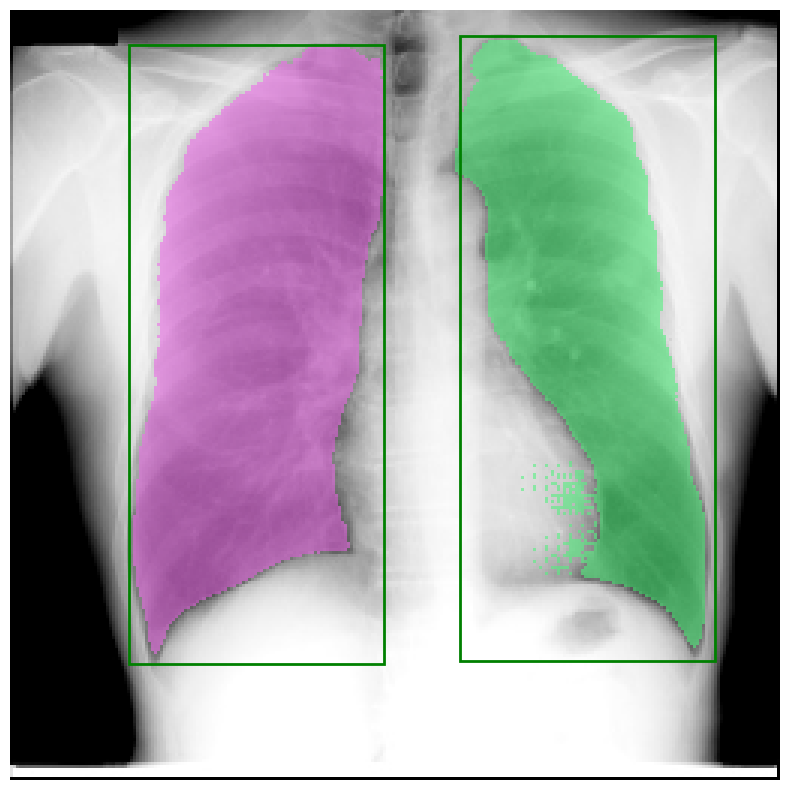

In [ ]:
image = x_train[0]
input_boxes= bb_train[0].to(device)

predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [ ]:
#!pip install torchmetrics
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, boxes, mask_gt in zip(x_val, bb_val, y_val):
    predictor.set_image(img)
    input_boxes = boxes
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2]).to(device)
    mask, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    mask = mask[0] + mask[1]
    f1.update(torch.tensor(mask).squeeze().to("cpu"), torch.tensor(mask_gt))
    f1_scores.append(f1.compute())

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

/tmp/ipykernel_5829/3413088159.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1.update(torch.tensor(mask).squeeze().to("cpu"), torch.tensor(mask_gt))


Mean F1 score: 0.9141
Standard deviation: 0.0091


# Object Detection Model to predict Bounding Boxes

In [ ]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes
from torch.utils.data import Dataset, DataLoader

import os
import torch

from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

class LungDataset(Dataset):
    def __init__(self, images, bb, transforms):
        self.images = images
        self.transforms = transforms
        self.boxes = bb
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = tv_tensors.Image(self.images[idx].reshape(3, 256, 256))

        boxes = self.boxes[idx]
        print(boxes.shape)
        
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image)),
            "labels": torch.ones(2, dtype=torch.int64),
            "image_id": idx,
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros(2, dtype=torch.uint8),
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target
    
train_dataset = LungDataset(x_train, bb_train, get_transform(train=True))
train_dataset[0]


torch.Size([2, 4])


(tensor([[[0.4549, 0.4431, 0.4431,  ..., 0.0000, 0.0000, 0.0000],
          [0.5843, 0.5843, 0.6196,  ..., 0.4667, 0.4549, 0.4549],
          [0.0000, 0.0000, 0.0000,  ..., 0.5686, 0.5686, 0.5843],
          ...,
          [0.4000, 0.4000, 0.4353,  ..., 0.3804, 0.4314, 0.4314],
          [0.0000, 0.0000, 0.0000,  ..., 0.4431, 0.4431, 0.4000],
          [0.4902, 0.4588, 0.4588,  ..., 0.5373, 0.5373, 0.5373]],
 
         [[0.4588, 0.4588, 0.4392,  ..., 0.4235, 0.4902, 0.4902],
          [0.0000, 0.0000, 0.0000,  ..., 0.4824, 0.4824, 0.4588],
          [0.5451, 0.4980, 0.4980,  ..., 0.5059, 0.5059, 0.5059],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
          [0.2549, 0.2314, 0.2314,  ..., 0.0000, 0.0000, 0.0000],
          [0.8784, 0.8784, 0.8784,  ..., 0.2431, 0.2549, 0.2549]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.8706, 0.8784],
          [0.2549, 0.2353, 0.2353,  ..., 0.0000, 0.0000, 0.0000],
          [0.8745, 0.8745, 0.8745,  ...,

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_lung_detection():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


In [ ]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [ ]:

def collate_fn(batch):
    return tuple(zip(*batch))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = LungDataset(x_train, bb_train, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

torch.Size([2, 4])
torch.Size([2, 4])
{'loss_classifier': tensor(0.6142, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2095, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1388, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0157, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our d
dataset = LungDataset(x_train, bb_train, get_transform(train=True))
dataset_test = LungDataset(x_val, bb_val, get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_lung_detection()

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

torch.Size([2, 4])
torch.Size([2, 4])
Epoch: [0]  [ 0/56]  eta: 0:00:34  lr: 0.000096  loss: 1.2561 (1.2561)  loss_classifier: 0.9746 (0.9746)  loss_box_reg: 0.1571 (0.1571)  loss_objectness: 0.1081 (0.1081)  loss_rpn_box_reg: 0.0163 (0.0163)  time: 0.6229  data: 0.0015  max mem: 5744
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
Epoch: [0]  [10/56]  eta: 0:00:11  lr: 0.001004  loss: 0.6706 (0.7860)  loss_classifier: 0.2993 (0.4757)  loss_box_reg: 0.2302 (0.2324)  loss_objectness: 0.0579 (0.0611)  loss_rpn_box_reg: 0.0150 (0.0168)  time: 0.2409  data: 0.0013  max mem: 5744
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size

KeyboardInterrupt: 

[array([[154.4375   ,  22.873116 , 228.70335  , 220.13773  ],
       [ 35.34767  ,  27.569061 , 114.08617  , 225.71808  ],
       [104.78709  ,  24.251211 , 218.60553  , 201.49867  ],
       [106.597885 ,  35.763958 , 231.02812  , 129.55818  ],
       [ 15.595722 ,  38.640617 , 127.998116 , 130.35403  ],
       [ 77.61541  ,   2.1948242, 169.8478   , 235.51752  ],
       [ 71.4061   ,  33.295498 , 137.95927  , 199.24434  ],
       [  8.010361 ,  19.224096 ,  91.401436 , 177.91324  ],
       [110.41261  , 105.77345  , 234.12553  , 209.33298  ],
       [127.96908  ,   3.978374 , 241.92587  , 162.03766  ]],
      dtype=float32), array([[154.23972  ,  22.901337 , 229.08086  , 224.15495  ],
       [ 36.948257 ,  27.000849 , 120.52097  , 220.05241  ],
       [127.97804  ,   9.645547 , 206.78085  , 240.23105  ],
       [107.59031  ,  25.988901 , 242.6448   , 174.75687  ],
       [ 21.714638 ,  38.406555 , 180.29718  , 166.24019  ],
       [ 29.817474 ,  39.961338 , 148.69644  , 123.791664 ],


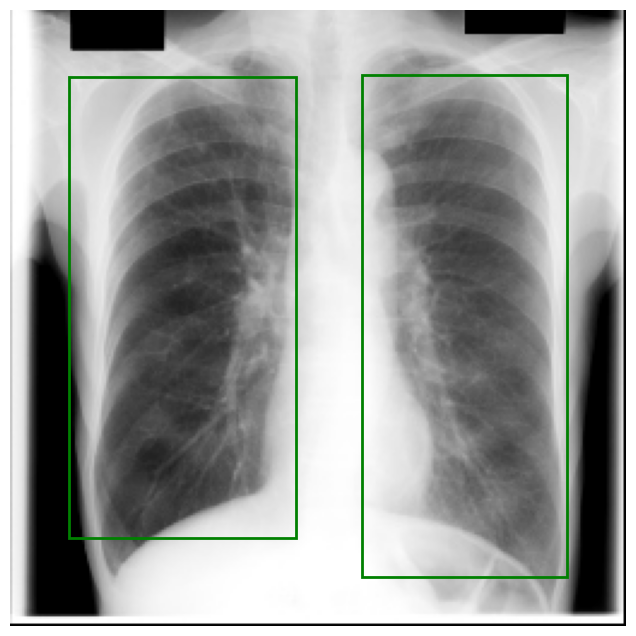

In [ ]:
eval_transform = get_transform(train=False)

def get_predicted_boxes(model, data):   
    model.eval()
    with torch.no_grad():
        boxes = []
        for img in data:
            img = tv_tensors.Image(img.reshape(3, 256, 256))
            x = eval_transform(img)
            x = x[:3, ...].to(device)
            predictions = model([x, ])
            pred = predictions[0]
            boxes.append(pred["boxes"].cpu().numpy())
    return boxes

boxes = get_predicted_boxes(model, x_val)

plot_image_with_bounding_box(x_val[5], boxes[5][0], boxes[5][1])


#write the boxes to a file using numpy
print(boxes)
    

In [ ]:
#!pip install torchmetrics
import torchmetrics

f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

predictor = SamPredictor(sam)

for img, boxes, mask_gt in zip(x_val, bb_val, y_val):

    predictor.set_image(img)
    input_boxes = boxes
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2]).to(device)
    mask, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    mask = mask[0] + mask[1]
    f1.update(torch.tensor(mask).squeeze().to("cpu"), torch.tensor(mask_gt))
    f1_scores.append(f1.compute())

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

NameError: name 'SamPredictor' is not defined